In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
from scipy.signal import resample_poly
import matplotlib.ticker as mticker
from matplotlib.patches import Rectangle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from joblib import Parallel, delayed
from tqdm import tqdm

from utils import load_pickle,extract_used_data,set_params
from utils.config import Params

In [51]:
data = load_pickle("../../data/flexible_shift/RDP02-PFCsep.pkl")
data = extract_used_data(data)

params = set_params(tt_preset="basic",
                    bt_preset="basic",
                    len_pos_average=10,
                    gaussian_sigma=25)

ana_tt = "*"
ana_bt = "*"

data_AB = []
data_BA = []

for index in params.ana_index_grid(ana_tt, ana_bt):

    trial_type = params.tt[index[0]]
    fr = data["simple_firing"][index]
    if fr is None:
        continue

    fr = gaussian_filter1d(fr, sigma=params.gaussian_sigma, axis=2, mode="nearest", truncate=3.0)
    k = params.len_pos_average
    len_track = fr.shape[2]
    fr = fr[:,:,:(len_track - len_track % k)]
    fr = resample_poly(fr, up=1, down=k, axis=2)
    
    if "CAB" in trial_type or "ACB" in trial_type or "ABC" in trial_type:
        data_AB.append(fr)
    elif "CBA" in trial_type or "BCA" in trial_type or "BAC" in trial_type:
        data_BA.append(fr)
    else:
        raise ValueError("Trial type not recognized:", trial_type)

data_AB = np.concatenate(data_AB, axis=1)
data_BA = np.concatenate(data_BA, axis=1)

In [52]:
data_AB.shape, data_BA.shape

((321, 78, 318), (321, 67, 318))

In [ ]:
def _task_score(task, X_all, labels, splits, random_state):
    """
    task = (is_shuffle, shuffle_idx, fold_idx, time_idx)
    """
    is_shuffle, shuffle_idx, fold_idx, t = task

    if is_shuffle:
        rng = np.random.RandomState(random_state + shuffle_idx)
        perm_labels = rng.permutation(labels)
        y = perm_labels
    else:
        y = labels

    train_idx, test_idx = splits[fold_idx]

    X_t = X_all[:, :, t].T  # (n_trials, n_neurons)
    X_train, X_test = X_t[train_idx], X_t[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", LinearSVC(C=1.0, max_iter=20000))
    ])

    clf.fit(X_train, y_train)
    return (fold_idx, t, float(clf.score(X_test, y_test)))


def decode_and_shuffle(data_AB, data_BA,
                                n_splits=5, n_repeats=10,
                                n_shuffles=100,
                                n_jobs=12,
                                random_state=0):
    
    rng = np.random.RandomState(random_state)

    neurons, n_AB, n_time = data_AB.shape
    _, n_BA, _ = data_BA.shape

    X_all = np.concatenate([data_AB, data_BA], axis=1)
    labels = np.concatenate([
        np.zeros(n_AB, dtype=int),
        np.ones(n_BA, dtype=int)
    ])

    cv = RepeatedStratifiedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=random_state
    )
    splits = list(cv.split(np.zeros(len(labels)), labels))
    n_folds = len(splits)

    # build tasks
    tasks = []

    # real
    for fold_idx in range(n_folds):
        for t in range(n_time):
            tasks.append((False, 0, fold_idx, t))

    # shuffle
    for i_shuf in range(n_shuffles):
        for fold_idx in range(n_folds):
            for t in range(n_time):
                tasks.append((True, i_shuf, fold_idx, t))

    total_tasks = len(tasks)

    # wrap tasks with tqdm
    def task_generator():
        for task in tqdm(tasks, desc="Shuffle & Decode progress", total=total_tasks):
            yield task

    # parallel compute
    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(_task_score)(task, X_all, labels, splits, random_state)
        for task in task_generator()
    )

    # aggregate as before...
    scores_real = np.zeros((n_folds, n_time), dtype=float)
    scores_shuffle = np.zeros((n_shuffles, n_folds, n_time), dtype=float)

    # fill in real
    idx = 0
    for fold_idx, t, sc in results[: n_folds * n_time]:
        scores_real[fold_idx, t] = sc

    start = n_folds * n_time
    for i_shuf in range(n_shuffles):
        for fold_idx in range(n_folds):
            for t in range(n_time):
                _, _, sc = results[
                    start + i_shuf * n_folds * n_time + fold_idx * n_time + t
                ]
                scores_shuffle[i_shuf, fold_idx, t] = sc

    # compute mean, sem, shuffle bands, clusters (same as before)
    mean_acc = np.mean(scores_real, axis=0)
    sem_acc  = np.std(scores_real, axis=0, ddof=1) / np.sqrt(n_folds)
    shuffle_means = np.mean(scores_shuffle, axis=1)
    shuffle_lower = np.percentile(shuffle_means, 2.5, axis=0)
    shuffle_upper = np.percentile(shuffle_means, 97.5, axis=0)

    sig_mask = mean_acc > shuffle_upper
    clusters = []
    current = None
    for i, v in enumerate(sig_mask):
        if v:
            if current is None:
                current = [i, i]
            else:
                current[1] = i
        else:
            if current is not None:
                clusters.append(tuple(current))
                current = None
    if current:
        clusters.append(tuple(current))

    real_cluster_stats = []
    for start_idx, end_idx in clusters:
        stat = np.sum(mean_acc[start_idx:end_idx+1] - shuffle_upper[start_idx:end_idx+1])
        real_cluster_stats.append((start_idx, end_idx, stat))

    null_cluster_stats = []
    for i in range(n_shuffles):
        perm = shuffle_means[i]
        perm_mask = perm > shuffle_upper
        c = None
        for j, v in enumerate(perm_mask):
            if v:
                if c is None: c = [j, j]
                else:        c[1] = j
            else:
                if c is not None:
                    mass = np.sum(perm[c[0]:c[1]+1] - shuffle_upper[c[0]:c[1]+1])
                    null_cluster_stats.append(mass)
                    c = None
        if c:
            mass = np.sum(perm[c[0]:c[1]+1] - shuffle_upper[c[0]:c[1]+1])
            null_cluster_stats.append(mass)

    null_cluster_stats = np.array(null_cluster_stats)

    cluster_signif = []
    for start_idx, end_idx, stat in real_cluster_stats:
        pval = (np.sum(null_cluster_stats >= stat) + 1) / (len(null_cluster_stats) + 1)
        cluster_signif.append((start_idx, end_idx, pval))

    return mean_acc, sem_acc, shuffle_lower, shuffle_upper, cluster_signif


In [67]:
def plot_decoding_with_zones(data: dict, params: Params, mean_acc, sem_acc, shuffle_lower, shuffle_upper, cluster_signif):

    n_time = len(mean_acc)
    X = np.arange(n_time)

    zones_color = {
        1: "#1f77b4",
        3: "#1f77b4",
    }
    acc_color = "#2ca02c"


    plt.figure(figsize=(6, 3))
    ax = plt.gca()

    # mean + sem
    ax.plot(X, mean_acc, color=acc_color)
    ax.fill_between(X, mean_acc - sem_acc, mean_acc + sem_acc, color=acc_color, alpha=0.4)

    # shuffle band
    ax.fill_between(X, shuffle_lower, shuffle_upper, color="gray", alpha=0.4)

    # chance line
    ax.axhline(0.5, linestyle="--", color="k")

    # cluster significance highlight
    for start, end, p in cluster_signif:
        if p < 0.05:
            ax.axvspan(start, end, facecolor="black", alpha=0.2)

    # zones background (horizontal bars)
    x0, x1 = ax.get_xlim()
    eps = 0.002 * (x1 - x0)
    h_frac = 0.05

    zones = data["zones"]

    for zi, row in enumerate(zones):

        if zi not in zones_color: continue

        start_x = row[0] / params.space_unit / params.len_pos_average
        end_x   = row[1]   / params.space_unit / params.len_pos_average

        ax.axvline(start_x, linestyle="--", color="k", linewidth=1)
        ax.axvline(end_x,   linestyle="--", color="k", linewidth=1)

        color_zone = zones_color[zi]

        # rect = Rectangle(
        #     (start_x - eps, 1.0 - h_frac),
        #     end_x - start_x + 2*eps, h_frac,
        #     transform=ax.get_xaxis_transform(),
        #     facecolor=color_zone,
        #     edgecolor="none",
        #     clip_on=False,
        #     zorder=6,
        # )
        # ax.add_patch(rect)

    # aesthetics
    ax.set_ylim(0, 1.02)
    ax.set_xlabel("Position (cm)", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, pos: f"{x*params.space_unit*params.len_pos_average:g}")
    )
    ax.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()

In [55]:
mean_acc, sem_acc, shuffle_lower, shuffle_upper, cluster_signif = decode_and_shuffle(data_AB, data_BA)

Shuffle & Decode progress:   0%|          | 0/810900 [00:00<?, ?it/s]

Shuffle & Decode progress:  20%|██        | 165143/810900 [07:31<29:23, 366.08it/s] 


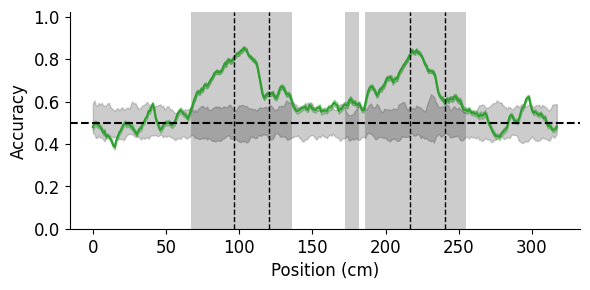

In [68]:
plot_decoding_with_zones(data, params, mean_acc, sem_acc, shuffle_lower, shuffle_upper, cluster_signif)